In [5]:
import os
import torch
from torch import nn
import torchvision as tv
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary


In [2]:
model = torch.hub.load("facebookresearch/WSL-Images", "resnext101_32x8d_wsl")

Downloading: "https://github.com/facebookresearch/WSL-Images/zipball/main" to /home/ashatya/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /home/ashatya/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

In [4]:
# slicing the model. Removing the last layer of the model
model = nn.Sequential(*list(model.children())[:-1])

In [7]:
summary(model, input_size=(3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,408
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5          [-1, 256, 28, 28]          16,384
       BatchNorm2d-6          [-1, 256, 28, 28]             512
              ReLU-7          [-1, 256, 28, 28]               0
            Conv2d-8          [-1, 256, 28, 28]          18,432
       BatchNorm2d-9          [-1, 256, 28, 28]             512
             ReLU-10          [-1, 256, 28, 28]               0
           Conv2d-11          [-1, 256, 28, 28]          65,536
      BatchNorm2d-12          [-1, 256, 28, 28]             512
           Conv2d-13          [-1, 256, 28, 28]          16,384
      BatchNorm2d-14          [-1, 256,

## Preprocessing

In [8]:
preprocess = transforms.Compose([
    transforms.Resize(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Dataset Preparation

In [2]:
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, RandomAffine, ColorJitter
from torchvision.io import read_image, write_jpeg

In [3]:
import os
os.chdir("/media/ashatya/Data/work/self/thesis/humanlike-ocr")
from generator import CharacterGenerator
import matplotlib.pyplot as plt
import tqdm
import pandas as  pd

In [4]:
vocab = "कखग‍ङचछजझ‍ञ‌‌‍टठडढणतथदधनपफबभमयरलवशषसह"
num_samples = 10
font_family = [ "Samyak-Devanagari.ttf", "Lohit-Devanagari.ttf"]

In [5]:
trans = Compose([
    RandomAffine(degrees=0, translate=(0.2, 0)),
    ColorJitter()
])

In [6]:
gen = CharacterGenerator(vocab=vocab, num_samples=num_samples, font_family=font_family, img_transforms=trans)

In [88]:
gen.data

[]

In [91]:
len(gen)

10

In [8]:
gen[0][0]

'torch.ByteTensor'

In [9]:
img_dir = "data/atomic_char"

In [10]:
dict_annotations : dict[str, list[str, int]] = {"filename": [], "label": []}
corrupt_labels = {3, 9, 11, 12, 13}
for iteration in range(5):
    for i in tqdm.tqdm(range(len(vocab))):
        img, target = gen[len(vocab) * iteration + i]
        # save the image
        if target not in corrupt_labels:
            name_file = f"atomic_{target}_{iteration}.jpg"
            write_jpeg(img, filename=os.path.join(img_dir, name_file))
            dict_annotations["filename"].append(name_file)
            dict_annotations["label"].append(target)
        

100%|██████████| 37/37 [00:00<00:00, 257.29it/s]


In [11]:
annotations = pd.DataFrame(dict_annotations)
annotations.to_csv("data/annotations_atomic_char_5iter.csv", index=False)

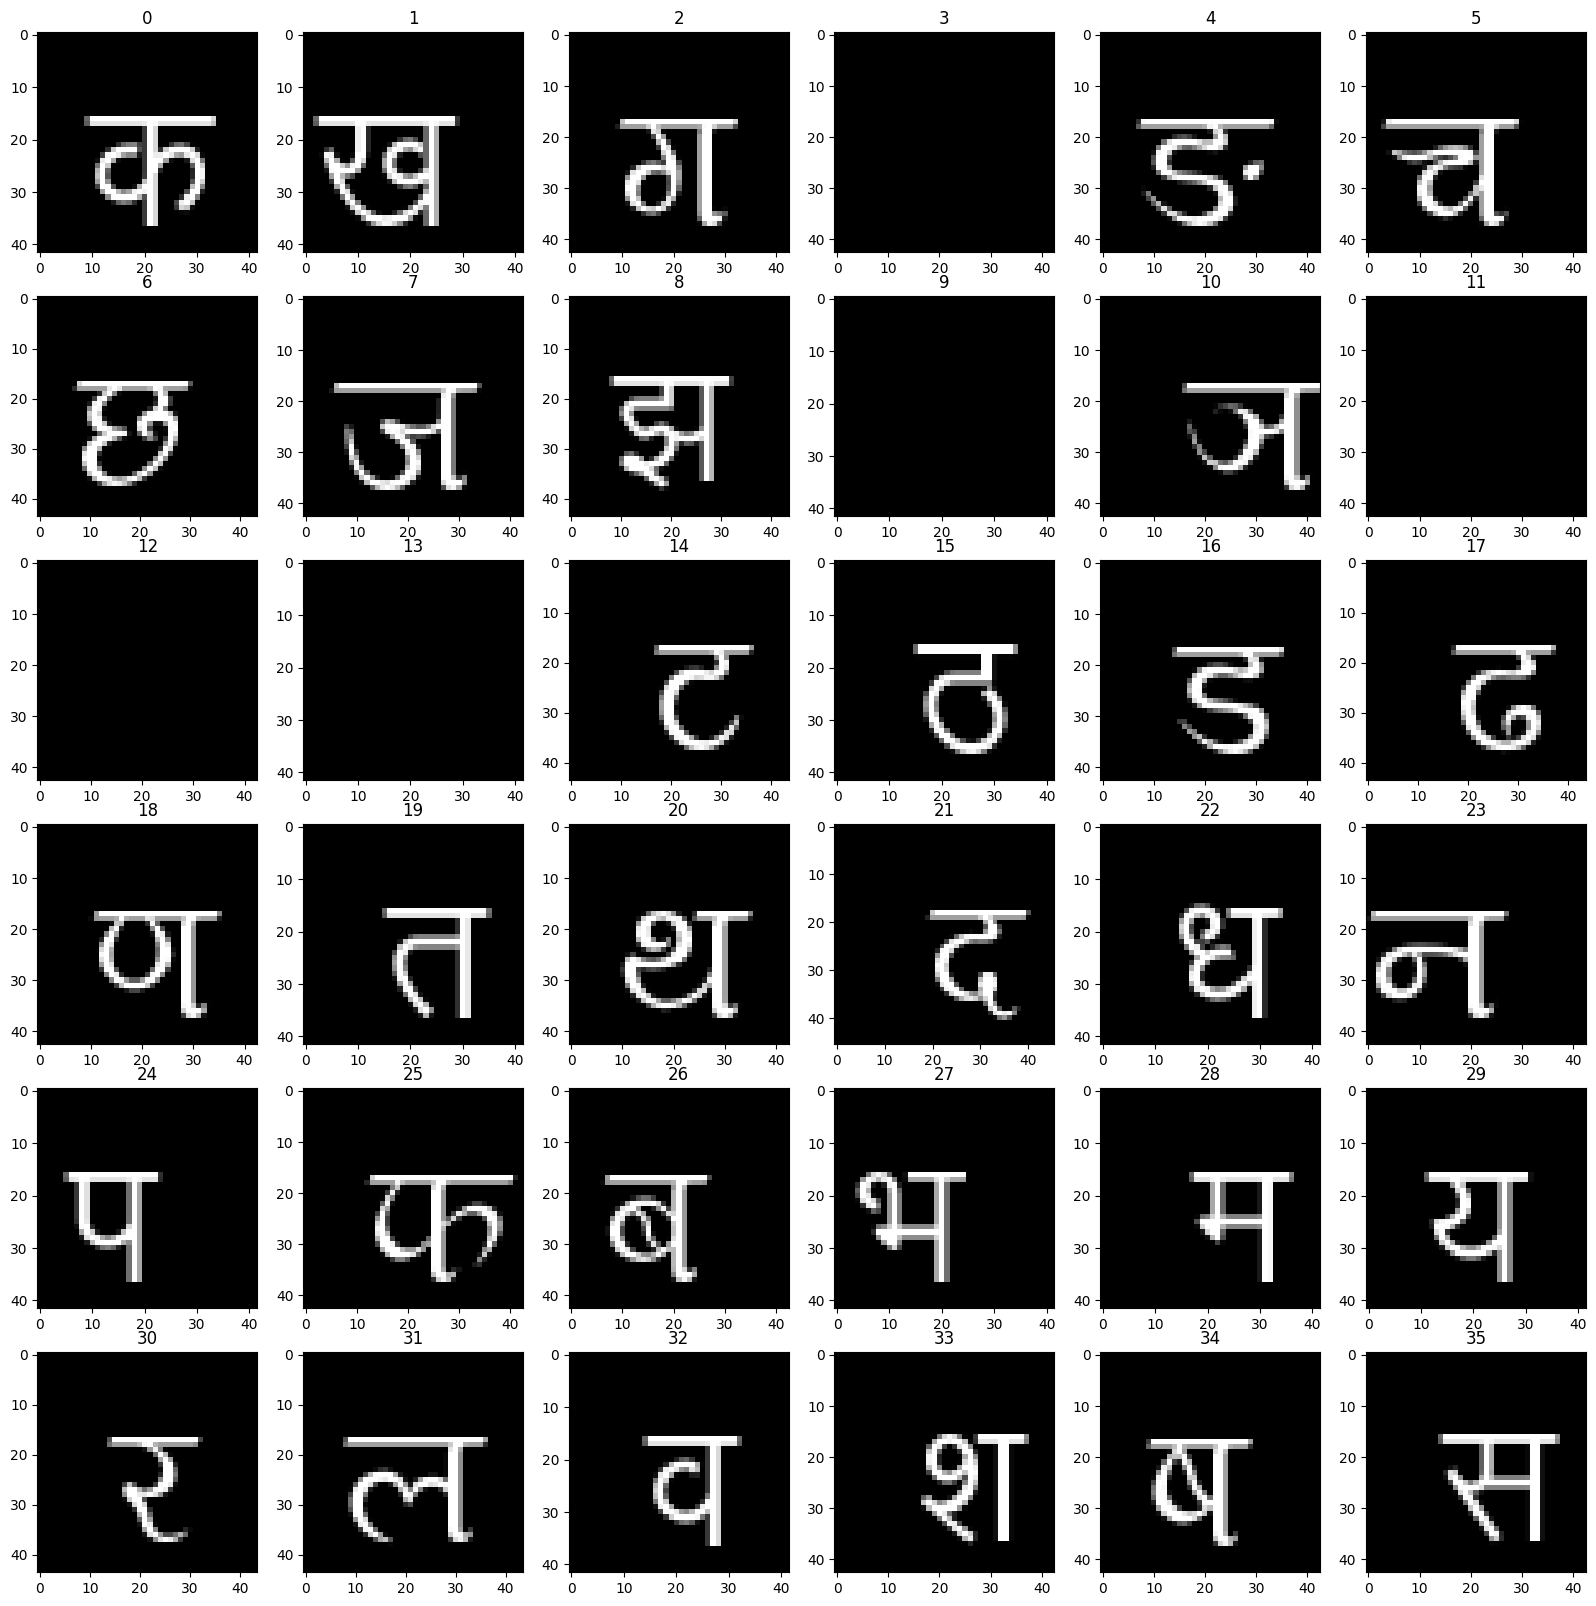

In [116]:
plt.figure(figsize=(20,20))
for i in range(1,len(vocab)):
    img, target = gen[i-1] #11, 12, 13
    # print(target)
    plt.subplot(6, 6, i)
    plt.title(target)
    plt.imshow(img.permute(1, 2, 0))
    # 3, 9, 11, 12, 13

# Creating Torch Dataset

In [133]:
class dataAtomicChars(Dataset):
    def __init__(self, annotations_file, img_dir) -> None:
        super().__init__()
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[index, 1]
        return image, label
    
train_data = dataAtomicChars("data/annotations_atomic_char_5iter.csv", "data/atomic_char")

In [12]:
img = read_image("data/atomic_char/atomic_0_0.jpg")

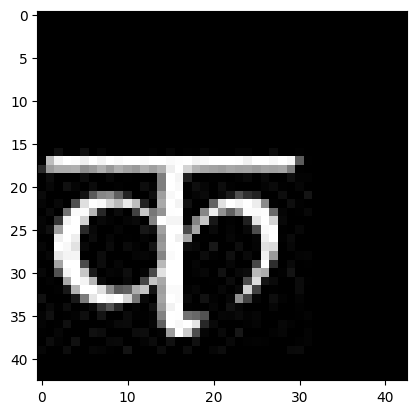

In [13]:
plt.imshow(img.permute(1, 2, 0))

## Using DataLoader to create a pipeline

In [134]:
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)


In [ ]:
# loading model
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')

In [ ]:
from torch import nn
from torchsummary import summary

# Dropping output layer (the ImageNet classifier)

def slice_model(original_model, from_layer=None, to_layer=None):
    return nn.Sequential(*list(original_model.children())[from_layer:to_layer])
model_conv_features = slice_model(model, to_layer=-1).to(device)
summary(model_conv_features, input_size=(3,224,224))

In [ ]:
from PIL import Image
from torchvision import transforms
# pre-processing required by ResNext
preprocess = transforms.Compose([
    transforms.Resize(40),
    transforms.CenterCrop(224),
    transforms.ConvertImageDtype(torch.float),
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
root = "/data/atomic_char"
annFile = "/data/annotations_atomic_char_5iter.csv"

In [ ]:
from torch.utils.data import Dataset
from torchvision.io.image import read_image
import pandas as pd
import os


class dataAtomicChars(Dataset):
    def __init__(self, annotations_file, img_dir, transforms) -> None:
        super().__init__()
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transforms = transforms
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = read_image(img_path)
        if self.transforms:
          image = self.transforms(image)
        label = self.img_labels.iloc[index, 1]
        return image, label
    
train_data = dataAtomicChars(annFile, root, preprocess)

In [ ]:
import multiprocessing

cpu_count = multiprocessing.cpu_count()
print('cpus', cpu_count)
batch_size = 10

data_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=cpu_count,
                                          collate_fn=lambda x: x)

In [ ]:
from tqdm import tqdm
features_list = []
labels_list = []

# Use GPUs to speed up the inference, this should take around 10 minutes

model_conv_features.to(device)
for batch in tqdm(data_loader):
    image_batch, label_batch = [x[0] for x in batch], [x[1] for x in batch]
    image_batch = torch.stack(image_batch).to(device) 

    with torch.no_grad():
        features_batch = model_conv_features(image_batch).flatten(start_dim=1)
    features_list.append(features_batch)
    labels_list.extend(label_batch)
        

In [ ]:
import os
# concat features
features = torch.cat(features_list)
features.shape

In [ ]:
X = features.to("cpu").numpy()

In [ ]:
df = pd.read_csv("/data/annotations_atomic_char_5iter.csv")
Y = df['label']

In [ ]:
# let's try to use the embedding feature space to predict the 80 COCO categories using a Random Forest
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

rfc = RandomForestClassifier(random_state=46, n_estimators=100, verbose=3)

X_rf = X

mlb = LabelBinarizer()
y_rf = mlb.fit_transform(np.array(Y))

y = np.array(Y)
y = np.where(y == None, 'NA', y)
# labels_frequency = pd.Series(y).value_counts()
# low_frequency_labels = labels_frequency[labels_frequency < 5].index
# y = np.where(np.isin(y, low_frequency_labels), 'other', y)

# split train and test stratyifing on the single-label target y
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf,
                                               test_size=0.2, random_state=46)

print(X_rf_train.shape, y_rf_train.shape,  X_rf_test.shape, y_rf_test.shape)
# train on the multi-label target y_multi
rfc.fit(X_rf_train, y_rf_train)
# shrink()

In [ ]:
rfc.score(X_rf_train, y_rf_train), rfc.score(X_rf_test, y_rf_test)

In [ ]:
# top 25 features selected by the random forest multiclass classifier
top_features = np.argsort(rfc.feature_importances_)[::-1][:80]
top_features  
""""array([ 719,  862, 1736,  634,  655,  419,  183, 1937,  405,  588,  132,
       1080,  507,  882,  196, 1445, 1251, 1542,  863,  633,   67, 1716,
       1204,  878,  600, 1166,  423, 1693, 1876,  245, 1120,  185, 1040,
       1819, 1747, 1617,  459, 1280,  279, 1593,  785,  289,  705,  713,
        340, 1208, 1224,  975, 1265,  837, 1037, 1930,  685, 1469,  179,
        239, 1154,  542,  636,  945, 1125, 1107, 1530,  763, 1175,   49,
        874, 1170, 1737, 1156, 1161, 1332, 1078,  946, 1400,  689, 1289,
       1540, 1228, 1535])"""

In [ ]:
# Extracting all of the principal components 

from sklearn.decomposition import PCA
pca = PCA(n_components=160)
X_pca = pca.fit_transform(X)
plt.plot(range(X_pca.shape[1]), np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative sum of explained variance by each component')
plt.show()